In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
from natsort import natsorted

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

from matplotlib.colors import LogNorm

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D

from astropy.stats import mad_std

import cometToolkit as ctk

from astropy.nddata import Cutout2D

In [3]:
mpl.rcParams.update({'font.size': 14})

# Finding ZeroPoint

In [27]:
Day = "Day17"
day = "day17"

vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{Day}/V/*"))[:-2]
rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{Day}/R/*"))[:-2]
bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{Day}/B/*"))[:-2]

vStackedStars = ctk.StackImages(vReducedDataPaths, preserveAvgCounts=False)
rStackedStars = ctk.StackImages(rReducedDataPaths, preserveAvgCounts=False)
bStackedStars = ctk.StackImages(bReducedDataPaths, preserveAvgCounts=False)

(array([56]),)
    xcentroid         ycentroid             peak              flux       
----------------- ------------------ ----------------- ------------------
132.9822006592052 1603.7641924497984 830.5281517747858 11.239543800082842


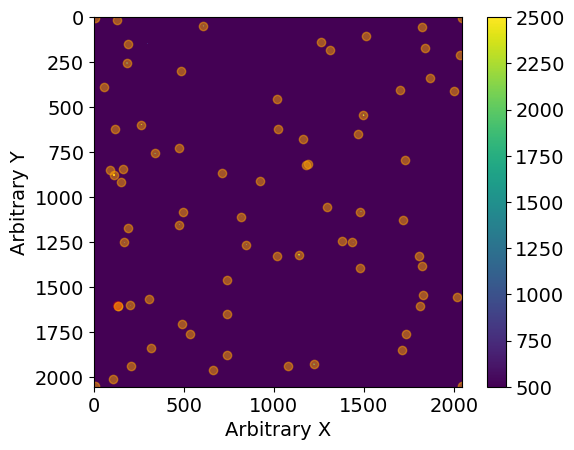

In [46]:
# Use to manually find star locations

image = bStackedStars

sources = ctk.SearchStars(image, fwhm=8, threshold=16, showPlot=True)

plt.imshow(image, vmin=500, vmax=2500)
plt.colorbar()

# Finding stars
starCentre = (130, 1600)
tolerance = 20
referenceStarIndices = np.where((abs(sources["xcentroid"] - starCentre[0]) < tolerance) & (abs(sources["ycentroid"] - starCentre[1]) < tolerance))
print(referenceStarIndices)
plt.scatter(sources[referenceStarIndices]["xcentroid"], sources[referenceStarIndices]["ycentroid"], alpha=0.5, color="orange")

plt.scatter(starCentre[0], starCentre[1], alpha=0.2, color="red")

print(sources[referenceStarIndices]["xcentroid", "ycentroid", "peak", "flux"])

In [47]:
# Calibration from APASS9
catalogDay12 = {
    "coordinates": np.array([(1720, 940), (1700, 1640)]),
    "vCalibratedMagnitudes": [12.376, 11.849],
    "bCalibratedMagnitudes": [12.932, 12.3],
    "sloan_r": [12.247, 11.75],
    "sloan_i": [12.077, 11.615]
}
catalogDay13 = {
    "coordinates": np.array([(115, 1420), (300, 1750)]),
    "vCalibratedMagnitudes": [16.25, 15.766],
    "bCalibratedMagnitudes": [16.763, 16.076],
    "sloan_r": [16.194, 15.649],
    "sloan_i": [15.713, 15.512]
}
catalogDay14 = {
    "coordinates": np.array([(1660, 530), (1650, 950)]),
    "vCalibratedMagnitudes": [13.073, 16.88],
    "bCalibratedMagnitudes": [13.647, 17.946],
    "sloan_r": [12.92, 16.617],
    "sloan_i": [12.735, 16.23]
}
catalogDay17 = {
    "coordinates": np.array([(110, 880), (130, 1600)]),
    "vCalibratedMagnitudes": [11.538, 13.919],
    "bCalibratedMagnitudes": [12.189, 15.119],
    "sloan_r": [11.357, 13.382],
    "sloan_i": [11.161, 12.887]
}

match Day:
    case "Day12": catalog = catalogDay12
    case "Day13": catalog = catalogDay13
    case "Day14": catalog = catalogDay14
    case "Day17": catalog = catalogDay17

[11.239999999999998, 13.264999999999999]


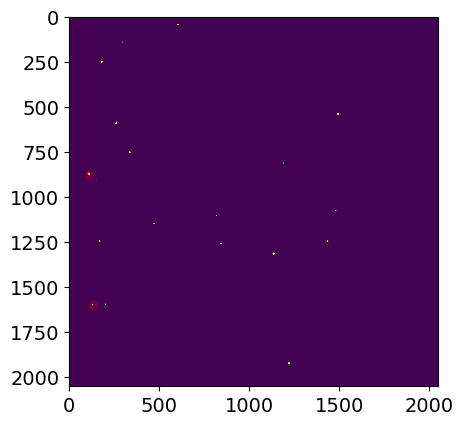

In [48]:
# Sloan r to Johnsons R
# Jordi et al.
# https://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Jordi2006
def JohnsonsR(sloan_r, sloan_i):
    # Note there are uncertainties on these transformations
    # Which can be included
    return -0.153 * (sloan_r - sloan_i) - 0.117 + sloan_r

catalog["rCalibratedMagnitudes"] = [JohnsonsR(r, i) for r, i in zip(catalog["sloan_r"], catalog["sloan_r"])]

print(catalog["rCalibratedMagnitudes"])

plt.imshow(vStackedStars, vmin=2000, vmax=3000)
plt.scatter(catalog["coordinates"][:,0], catalog["coordinates"][:,1], alpha=0.2, color="red")

19.636732497040384
20.020780649216945
18.707394833489055


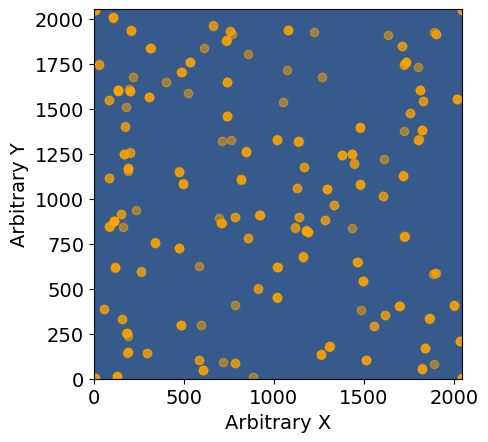

In [49]:
vZeroPoint = np.mean(ctk.DetermineStarZeroPoint(vStackedStars, len(vReducedDataPaths), catalog["coordinates"], catalog["vCalibratedMagnitudes"], apertureRadius=10, showPlot=True))
rZeroPoint = np.mean(ctk.DetermineStarZeroPoint(rStackedStars, len(rReducedDataPaths), catalog["coordinates"], catalog["rCalibratedMagnitudes"], apertureRadius=10, showPlot=True))
bZeroPoint = np.mean(ctk.DetermineStarZeroPoint(bStackedStars, len(bReducedDataPaths), catalog["coordinates"], catalog["bCalibratedMagnitudes"], apertureRadius=10, showPlot=True))
print(vZeroPoint)
print(rZeroPoint)
print(bZeroPoint)

# Aperture Curve

In [50]:
vImageStacked = ctk.GetImage(f"../DataProducts/StackedImages/{Day}/vStacked.fits")
rImageStacked = ctk.GetImage(f"../DataProducts/StackedImages/{Day}/rStacked.fits")
bImageStacked = ctk.GetImage(f"../DataProducts/StackedImages/{Day}/bStacked.fits")

In [53]:
def FindComet(image, showPlot=False):
    sources = ctk.SearchStars(image, showPlot=showPlot)

    tolerance = 20

    match Day:
        case "Day12": posX, posY = (570, 770)
        case "Day13": posX, posY = (570, 770)
        case "Day14": posX, posY = (490, 770)
        case "Day17": posX, posY = (570, 770)

    if showPlot:
        plt.scatter(posX, posY)
    

    indices = np.where((abs(sources["xcentroid"] - posX) < tolerance) & (abs(sources["ycentroid"] - posY) < tolerance))
    comet = sources[indices]

    print(comet)

    return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))

cometV = FindComet(vImageStacked)
cometR = FindComet(rImageStacked)
cometB = FindComet(bImageStacked)

 id     xcentroid     ...        flux               mag        
--- ----------------- ... ------------------ ------------------
149 574.5941334974668 ... 25.492273072661597 -3.516021404963916


/tmp/ipykernel_1790904/2598982032.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))


 id     xcentroid     ...        flux               mag        
--- ----------------- ... ------------------ ------------------
149 574.4050850076178 ... 29.656138765151525 -3.680286512874664


/tmp/ipykernel_1790904/2598982032.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))


 id     xcentroid        ycentroid     ...        flux               mag        
--- ----------------- ---------------- ... ----------------- -------------------
 78 574.5455111638405 774.477331721113 ... 16.44553176523166 -3.0401198023259446


/tmp/ipykernel_1790904/2598982032.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))


In [54]:
# Activity
from sbpy.data import Ephem
from sbpy.calib import solar_fluxd
from sbpy.activity import Afrho

import astropy.units as u

# Function to do this for range of apertures

In [55]:
def FindActivityCurve(image, comet, apertureRangeKm, zeroPoint, phase, showPlot=False):
    
    activity = []
    cometDistance = 0.585 * 1.496e8 # au to km

    for aKm in apertureRangeKm:
        # Convert aperture range from km to pixel
        aPixel = (180 * 3600) / (0.6 * np.pi) * np.arctan2(aKm, cometDistance)

        # Create aperture
        aperture = CircularAperture((comet[0], comet[1]), r=aPixel)

        # Find background
        background = Background2D(image, 50).background

        if showPlot:
            # Plot
            fig, ax = plt.subplots()

            ax.imshow(image - background, vmin=0, vmax=80)
            apertureCircle = plt.Circle((comet[0], comet[1]), aPixel, color="white", fill = 0)

            ax.add_patch(apertureCircle)

        phot_table = aperture_photometry(image - background, aperture)
        
        # find magnitude within aperture
        mag = -2.5 * np.log10(phot_table["aperture_sum"] / 120) + zeroPoint

        wavelength = 0.5501 * u.um

        mag = mag * u.ABmag # absolute magnitude
        #print(mag)

        aper = aKm * u.km

        eph = Ephem.from_dict({"rh": 1.566 * u.au, "delta": 0.585 * u.au})

        afrho = Afrho.from_fluxd(wavelength, mag, aper, eph)
        
        afrho_phaseCorrected = afrho.to_phase(0 * u.deg, phase * u.deg)

        activity.append(afrho.value)
        #print(afrho)

    return [apertureRangeKm, activity]

In [56]:
apertureRange = np.linspace(100, 25000, 40)

match Day:
    case "Day12": phase = 9.63 # degrees
    case "Day13": phase = 9.07
    case "Day14": phase = 8.64
    case "Day17": phase = 7.5


In [57]:
apRange, activityV = FindActivityCurve(vImageStacked, cometV, apertureRange, zeroPoint=vZeroPoint, phase=phase, showPlot=False)

In [58]:
apRange, activityR = FindActivityCurve(rImageStacked, cometR, apertureRange, zeroPoint=rZeroPoint, phase=phase, showPlot=False)

In [59]:
apRange, activityB = FindActivityCurve(bImageStacked, cometB, apertureRange, zeroPoint=bZeroPoint, phase=phase, showPlot=False)

In [60]:
def SaveActivityData(outputPath, apertureRange, activityV, activityR, activityB):

    data = np.array([apertureRange, np.squeeze(activityV), np.squeeze(activityR), np.squeeze(activityB)]).T

    np.savetxt(outputPath, data)

SaveActivityData(f"../DataProducts/Activity/{day}", apRange, activityV, activityR, activityB)

## Plotting

Text(0.5, 1.0, 'Activity Curve for 2024-03-17')

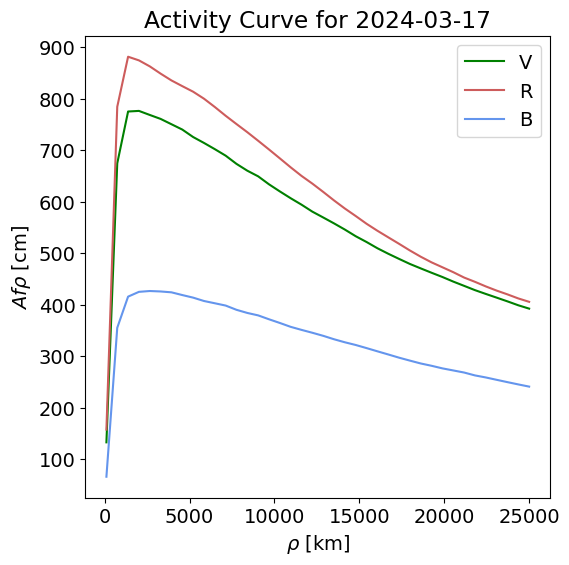

In [61]:
ctk.PlotAfrho(apRange, activityV, activityR, activityB, colours=["green", "indianred", "cornflowerblue"], figsize=(6,6))
plt.title(f"Activity Curve for 2024-03-{Day[3:]}")

# Activity Evolution Plot

../DataProducts/Activity/day12
../DataProducts/Activity/day13
../DataProducts/Activity/day14
../DataProducts/Activity/day17


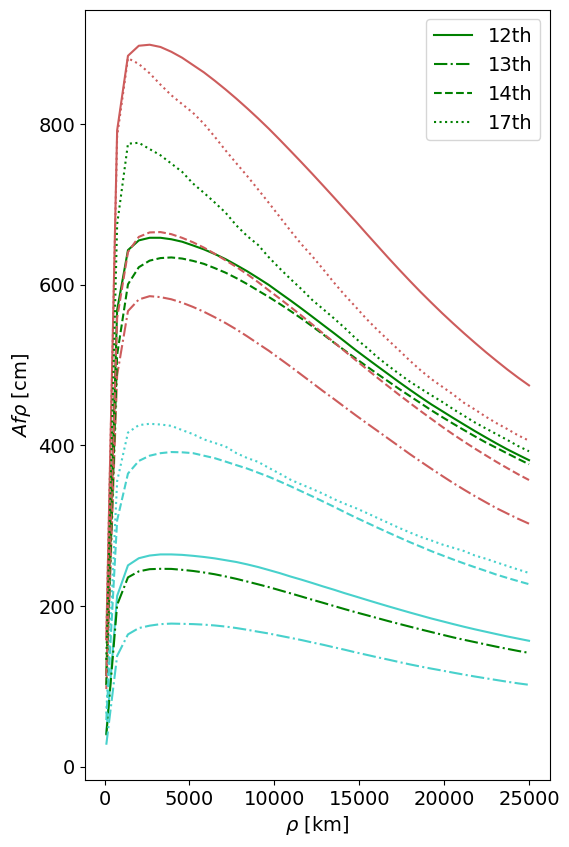

In [105]:
# Multiplot

from matplotlib import cm

# Loading data
dataPaths = natsorted(glob("../DataProducts/Activity/*"))
dayLabels = [path.split("/")[-1][3:] + "th" for path in dataPaths]

fig, ax = plt.subplots(figsize=(6,10))

lineStyles = ["solid", "dashdot", "dashed", "dotted"]
colours = ["green", "indianred", "mediumturquoise"]
#cmaps = [cm.get_cmap("summer"), cm.get_cmap("autumn"), cm.get_cmap("bone")]

for i, path in enumerate(dataPaths):

    print(path)

    data = np.loadtxt(path)

    apertures = data[:,0]
    activityV = data[:,1]
    activityR = data[:,2]
    activityB = data[:,3]

    ax.plot(apertures, activityV, color=colours[0], ls=lineStyles[i], label=dayLabels[i])
    ax.plot(apertures, activityR, color=colours[1], ls=lineStyles[i])
    ax.plot(apertures, activityB, color=colours[2], ls=lineStyles[i])

ax.set_ylabel(r"$Af\rho$ [cm]")
ax.set_xlabel(r"$\rho$ [km]")
ax.legend()

../DataProducts/Activity/day12
../DataProducts/Activity/day13
../DataProducts/Activity/day14
../DataProducts/Activity/day17


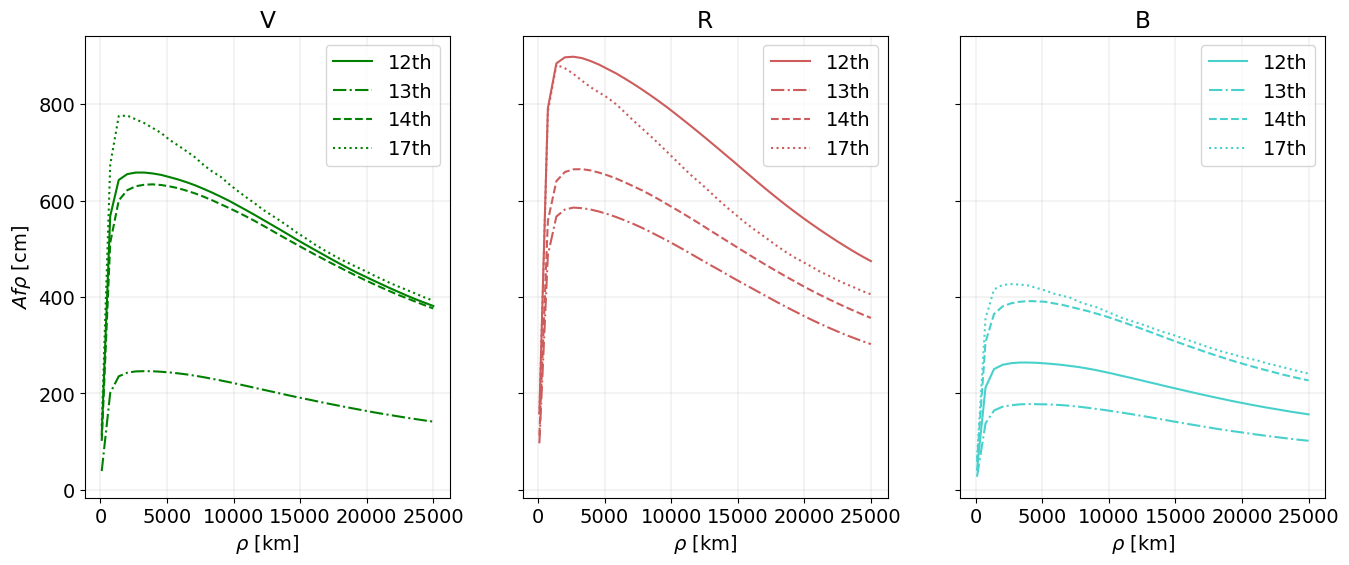

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(16,6), sharey=True)

ax0, ax1, ax2 = axes

lineStyles = ["solid", "dashdot", "dashed", "dotted"]
colours = ["green", "indianred", "mediumturquoise"]
#cmaps = [cm.get_cmap("summer"), cm.get_cmap("autumn"), cm.get_cmap("bone")]

for i, path in enumerate(dataPaths):

    print(path)

    data = np.loadtxt(path)

    apertures = data[:,0]
    activityV = data[:,1]
    activityR = data[:,2]
    activityB = data[:,3]

    ax0.plot(apertures, activityV, color=colours[0], ls=lineStyles[i], label=dayLabels[i])
    ax1.plot(apertures, activityR, color=colours[1], ls=lineStyles[i], label=dayLabels[i])
    ax2.plot(apertures, activityB, color=colours[2], ls=lineStyles[i], label=dayLabels[i])

ax0.set_ylabel(r"$Af\rho$ [cm]")

ax0.set_title("V")
ax1.set_title("R")
ax2.set_title("B")

for ax in axes:
    ax.set_xlabel(r"$\rho$ [km]")
    ax.legend()
    ax.grid(lw=0.2)